# Dynamical Systems Analysis of a Single Neuron Model

In [1]:
%matplotlib nbagg
import functools
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.interpolate as spolate

# Convenience functions in the local directory
from dynamical import poincaré_map, bifurcation_diagram, hybrid_sim

In [2]:
# Model for cortical RS pyramidal neuron taken from Izhikevich (2007)
C, k = 100, 0.7
vr, vt, vp = -60, -40, 35
a, b, c, d = 0.03, -2, -50, 100

Istar = k/4 * (vr - vt - b/k)**2

def jump_map(t, vu):
    return np.array([c,d]) + np.array([0,1]) * vu

def flow_map(I, t, vu):
    v, u = vu
    vdot = (k*(v - vr)*(v - vt) - u + I)/C
    udot = a * (b * (v - vr) - u)
    return np.array([vdot, udot])

def P(t, vu):
    return vu[0] - vp


In [43]:
# Find the Poincaré map of the neuron
from tqdm import tqdm_notebook as tqdm

tmax = 10000
u0s = np.linspace(-100, 500, num=21)
mus = np.geomspace(1, 1000, num=71)
x0s = jump_map(0, np.array([vp + 0*u0s, u0s]).T)

Tret, Xpcr = poincaré_map(flow_map, x0s, P, mus, tmax=tmax, progress_bar=tqdm)

71it [00:43,  1.62it/s]


### Saddle-Node Bifurcation
Demonstrates the saddle-node bifurcation of the resting state, which converges with the threshold then eventually disappears as input current increases. For these parameters, this occurs at $I = 51.4\text{pA}$.

<IPython.core.display.Javascript object>


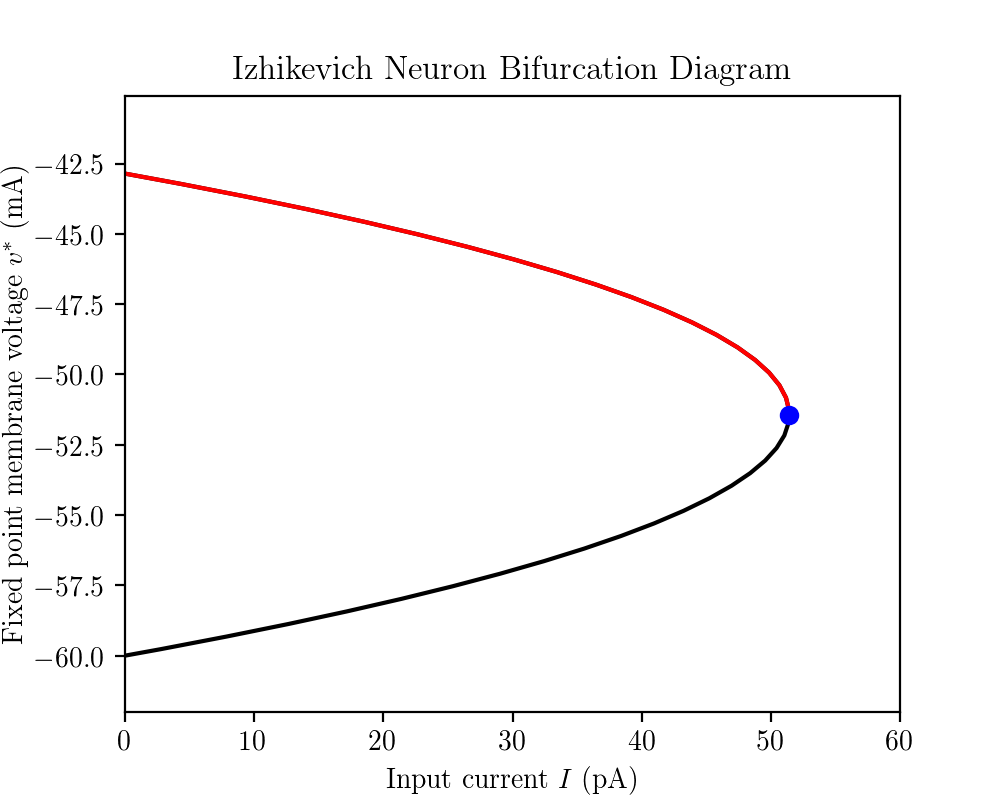

In [10]:
# Restriction of the system to the u nullcline.
def f(v,I):
    return (k*(v - vr)*(v - vt - b/k) + I)/C

# 1D system derivative wrt v
def fv(v,I):
    return k/C * (2*v - vr - vt - b/k) + 0*I

plt.figure(figsize=(5,4))
bifurcation_diagram(f, fv, np.linspace(-62, -40.1), np.linspace(0,60))
plt.plot(k*(vr - vt - b/k)**2 / 4, (vr + vt + b/k)/2, 'bo')
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Fixed point membrane voltage $v^*$ (mA)', labelpad=2)
plt.title('Izhikevich Neuron Bifurcation Diagram')

### The I-F Relation
The Poincaré and return-time maps are used to calculate how firing frequency changes with input current, for a constant input from the beginning of time (or after an initial transient). Two particular observations of interest are that (1) these RS neurons appear to exhibit class-I neural excitability, in that their firing frequency increases smoothly and varies over a wide range as input current increases, and (2) the firing frequency appears to follow approximately a 0.75-power law. 

(By the way, a previous version claimed that a source quoted a logarithmic scaling and attempted to reproduce it, but the reason it didn't work was that that result was for a model which undergoes a homoclinic orbit bifurcation, not the saddle node on invariant cycle which this neuron undergoes.)

In [11]:
# Find the fixed points and return times of the Poincaré map.
ustars = np.zeros_like(mus)
tstars = np.zeros_like(mus)

Upcr = Xpcr[:,:,1]
guesses = np.argmin(np.abs(Upcr - u0s), axis=1)

mupoints = np.tile(mus.reshape((-1,1)), (1,len(u0s)))[np.isfinite(Tret)]
u0points = np.tile(u0s.reshape((1,-1)), (len(mus),1))[np.isfinite(Tret)]
uvals = Upcr[np.isfinite(Tret)]
Pinterp = spolate.SmoothBivariateSpline(mupoints, u0points, uvals)

for i,mu in enumerate(mus):
    ustars[i] = spo.fixed_point(lambda u: Pinterp(mu, u), guesses[i])
    
    x0 = jump_map(0, np.array([[vp, ustars[i]]]))
    tstars[i] = poincaré_map(flow_map, x0, P, [mu], tmax=tmax)[0]

In [12]:
# Find closest linear fit to frequency, i.e. 1/I fit to period.
finites = np.isfinite(tstars)
if np.any(finites):
    alpha = np.poly1d(np.polyfit(mus[mus > 200], 1/tstars[mus > 200], deg=1))
else:
    alpha = lambda mus: mus*0


In [13]:
# Find a fit of the form a*r(I - I0)^k.
I0 = 51.4
def monom(params, mus):
    a, k = params
    out = np.zeros_like(mus)
    out[mus >= I0] = a * (mus[mus >= I0] - I0)**k
    return out

monom_params = spo.fmin(lambda params: np.sum((monom(params, mus[mus > 200])
                                               - 1/tstars[mus > 200])**2),
                        np.array([1e-4, 0.8]))
print(monom_params)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 95
         Function evaluations: 175
[ 0.0008502   0.75202044]


<IPython.core.display.Javascript object>


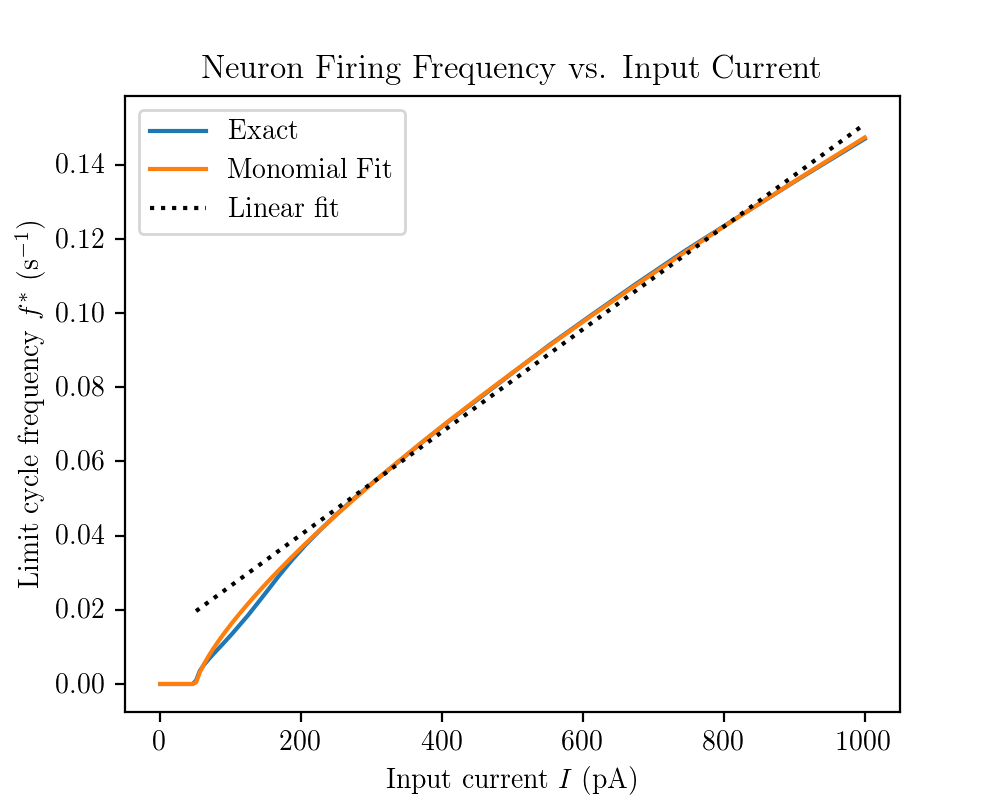

In [14]:
plt.figure(figsize=(5,4))
plt.plot(mus, 1/tstars, label='Exact')
plt.plot(mus, monom(monom_params, mus), label='Monomial Fit')
plt.plot(mus[finites], alpha(mus[finites]), 'k:', label='Linear fit')
plt.legend()
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Limit cycle frequency $f^*$ (s$^{-1}$)')
plt.title('Neuron Firing Frequency vs. Input Current')
xlim = plt.xlim()

### Simulation Across Multiple Firings
Above, we have terminated the simulation immediately when a cell fires. Here, a function is introduced which simulates the cell up to a given time regardless of the number of firings.

<IPython.core.display.Javascript object>


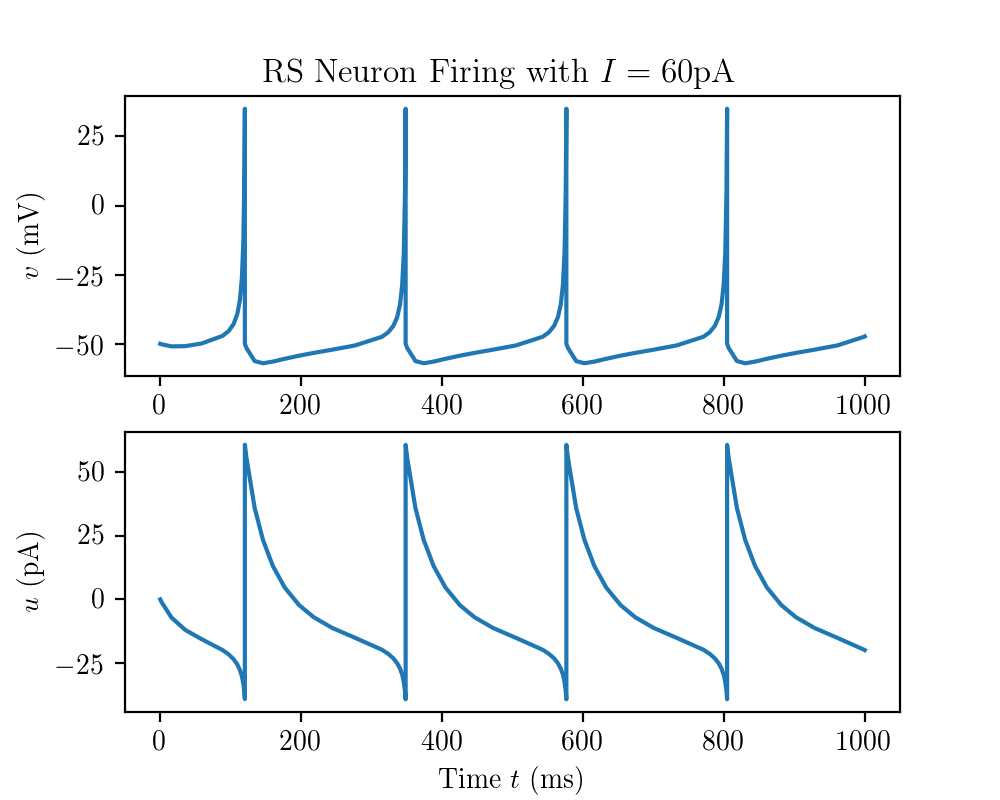

In [16]:
Itest = 60#pA
x0 = np.array([(vr + vt)/2, 0])
the_flow = functools.partial(flow_map, Itest)
tout, xout, tev = hybrid_sim(the_flow, jump_map, P, 
                             (0,1000), x0)

plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron Firing with $I = {}\\mathrm{{pA}}$'.format(Itest), y=0.925)

# Bibliography

Izhikevich E. M. (2007). _Dynamical Systems in Neuroscience_. MIT press.
> Source of the model of the cortical RS neuron used here.
